In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

import numpy
import scipy
from scipy.io import wavfile
from scipy import signal

class Noise(object):
    def __init__(self, duration=1, sample_rate=44100):
        self.duration = duration
        self.sample_rate = sample_rate
        self.samples = None
        self.resample()
        
    @property
    def n_samples(self):
        return int(self.duration * self.sample_rate)

    def resample(self):
        """Take a series of random samples from a gaussian distribution."""
        samples = numpy.random.normal(-1, 1, self.n_samples)
        samples -= samples.mean()
        self.samples = samples
    
    def integrate(self):
        """'Integrage' (i.e. do a cumulative sum of) the current sample set.
        This is useful because integrating white noise produces Brownian
        noise. 
        
        There's a wonderfully concrete way to understand that fact. Imagine 
        you're a particle that wiggles, and that each time you move, you 
        decide how to move by taking a sample from a Gaussian distribution. 
        If you plotted all your movements by starting from zero each time,
        you'd get a white noise (Gaussian noise) pattern. But if you plotted
        the resulting path, you'd get a Brownian noise pattern. The
        resulting path is just the sum of the individual movements; hence
        integrating (summing) white noise produces Brownian noise.
        """
        self.samples[:] = self.samples.cumsum()
        self.samples -= self.samples.mean()
        return self
    
    def butter_high(self, freq=2 ** -8, order=1):
        b, a = signal.butter(order, freq, 'high', analog=False)
        self.samples[:] = signal.lfilter(b, a, self.samples)
        return self

    def butter_low(self, freq=2 ** -1, order=1):
        b, a = signal.butter(order, freq, 'low', analog=False)
        self.samples[:] = signal.lfilter(b, a, self.samples)
        return self
    
    def butter_filter(self, lowpass=2 ** -1, highpass=2 ** -8, order=1):
        """Perform a high- and low-pass butterworth filter.
        """
        self.butter_low(lowpass, order)
        self.butter_high(highpass, order)
        return self

    def gauss_filter(self, sample_width=0.002):
        """Convolve with a unit area Gaussian kernel. This is the 
        same thing as a weighted moving average with a Gaussian 
        weight curve.
        """
        sample_width = int(self.sample_rate * sample_width)
        kernel = numpy.exp(-numpy.linspace(-3, 3, sample_width) ** 2)
        kernel /= kernel.sum()
        self.samples[:] = signal.convolve(self.samples, kernel, 'same')
        return self
    
    def square_filter(self, sample_width=0.002):
        """Convolve with a unit area constant kernel. This is the 
        same thing as an unweighted moving average.
        """
        sample_width = int(self.sample_rate * sample_width)
        kernel = numpy.exp(-numpy.linspace(-3, 3, sample_width) ** 2)
        kernel /= kernel.sum()
        self.samples[:] = signal.convolve(self.samples, kernel, 'same')
        return self
    
    def fade(self, sample_width=0.1):
        """Fade in at the beginning and out at the end. This softens the
        percieved 'click' at the beginning and end of the noise.
        """
        sample_width = int(self.sample_rate * sample_width)
        self.samples[:sample_width] *= numpy.linspace(0, 1, sample_width)
        self.samples[-sample_width:] *= numpy.linspace(1, 0, sample_width)
        return self

    def scale(self):
        """Scale the current data by the absolute maximum. This maximizes
        volume without causing clipping artifacts.
        """
        self.samples -= self.samples.mean()
        self.samples /= numpy.max(numpy.abs(self.samples))
        self.samples *= 32767  # max amplitude at 16 bits per sample
        return self
        
    def amplify(self, amplitude=1):
        """Amplify the tone using the settings passed in by the class
        constructor. This may produce clipping.
        """
        self.samples *= self.amplitude
        return self
    
    def wav(self):
        """Return data suitable for saving as a PCM or .wav file."""
        return numpy.int16(self.samples)
    
    def _mk_sample(self, filtered=False, faded=False, brownian=False,
                   gaussfilter=False, squarefilter=False, sample_width=0.002):
        self.resample()
        self.integrate() if brownian else None
        self.gauss_filter(sample_width) if gaussfilter else None
        self.square_filter(sample_width) if squarefilter else None
        self.butter_filter(order=5) if filtered else None
        self.fade() if faded else None
        self.scale()
        return self
    
    def brownian(self, filtered=False, faded=False):
        """Convenience method for generating Brownian noise."""
        return self._mk_sample(filtered, faded, brownian=True)
    
    def brownian_gaussfilter(self, filtered=False, faded=False, sample_width=0.002):
        """Conveninence method for generating Brownian noise
        passed through a gaussian filter. This produces
        especially soothing 'white' noise.
        """
        return self._mk_sample(filtered, faded, brownian=True, 
                               gaussfilter=True, sample_width=sample_width)
    
    def brownian_squarefilter(self, filtered=False, faded=False, sample_width=0.002):
        """Convenience function for generating white noise passed
        through a square filter.
        """
        return self._mk_sample(filtered, faded, brownian=True, 
                               squarefilter=True, sample_width=sample_width)

    def white(self, filtered=False, faded=False):
        """Convenience method for generating white noise."""
        return self._mk_sample(filtered, faded)
    
    def white_gaussfilter(self, filtered=False, faded=False, sample_width=0.002):
        """Convenience method for generating white noise passed
        through a gaussian filter.
        """
        return self._mk_sample(filtered, faded, gaussfilter=True, 
                               sample_width=sample_width)

    def white_squarefilter(self, filtered=False, faded=False, sample_width=0.002):
        """Convenience function for generating white noise passed
        through a square filter.
        """
        return self._mk_sample(filtered, faded, squarefilter=True, 
                               sample_width=sample_width)

    
noise = Noise(duration=30)
noise.brownian(filtered=True, faded=True)
plt.plot(noise.wav())
plt.show()
#wavfile.write('test.wav', noise.sample_rate, noise.wav())

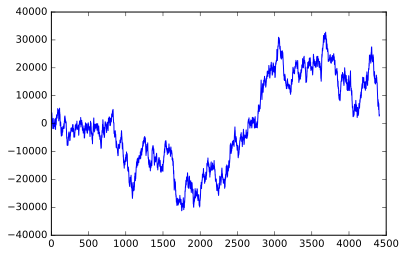

In [2]:
noise = Noise(duration=0.1)
samples = numpy.hstack([noise.brownian().wav().reshape(-1, 1) 
                        for x in range(2000)])
plt.plot(samples[:,0])
plt.show()

In [3]:
# Perform Singular Value Decomposition on the samples generated above.
# The shape of the basis vector functions is not predetermined; if you
# pass in white noise, they also look like white noise. But if you pass
# in Brownian noise, they look just like the basis functions of a 
# Fourier transform! This is mathematically provable; see the discussion
# of Wiener Processes (i.e. processes that generate Brownian noise) here: 
#
# https://en.wikipedia.org/wiki/Karhunen%E2%80%93Lo%C3%A8ve_theorem

U, s, V = numpy.linalg.svd(samples, full_matrices=False)

# This verifies that the SVD operation has produced reasonable results:

numpy.allclose(samples, U @ numpy.diag(s) @ V)

True

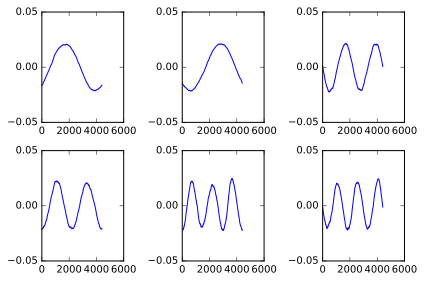

In [4]:
xbins = 3
ybins = 3
plt.subplot(2, 3, 1)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,0].reshape(-1))
plt.subplot(2, 3, 2)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,1].reshape(-1))
plt.subplot(2, 3, 3)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,2].reshape(-1))
plt.subplot(2, 3, 4)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,3].reshape(-1))
plt.subplot(2, 3, 5)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,4].reshape(-1))
plt.subplot(2, 3, 6)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,5].reshape(-1))
plt.tight_layout()
plt.show()

# Here are a few of the most significant basis functions. They 
# might be a little off, but they'll basically look like slightly 
# fuzzy sinusoidal curves with increasing frequencies.

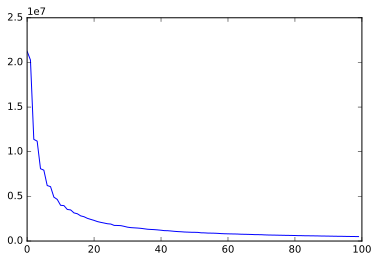

In [5]:
# This indicates how significant each of the basis functions
# are. As you can see, their significance drops off exponentially.
# The rate of drop-off can be modified by increasing or decreasing
# the overall power of the noise.

plt.plot(s[0:100])
plt.show()

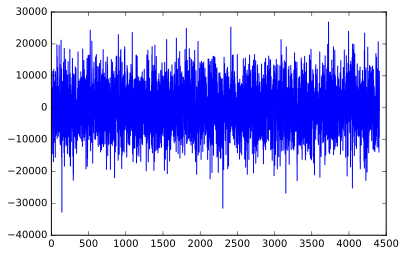

In [6]:
# When you do the same thing with white noise, the 
# basis functions are just more white noise.

noise = Noise(duration=0.1)
samples = numpy.hstack([noise.white().wav().reshape(-1, 1) 
                        for x in range(2000)])
plt.plot(samples[:,0])
plt.show()

In [7]:
U, s, V = numpy.linalg.svd(samples, full_matrices=False)
numpy.allclose(samples, U @ numpy.diag(s) @ V)

True

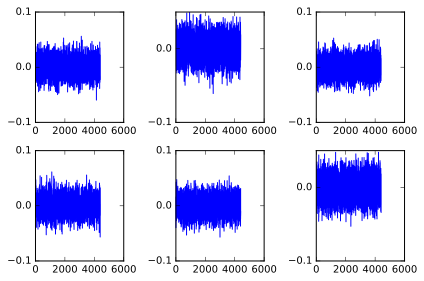

In [8]:
xbins = 3
ybins = 3
plt.subplot(2, 3, 1)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,0].reshape(-1))
plt.subplot(2, 3, 2)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,1].reshape(-1))
plt.subplot(2, 3, 3)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,2].reshape(-1))
plt.subplot(2, 3, 4)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,3].reshape(-1))
plt.subplot(2, 3, 5)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,4].reshape(-1))
plt.subplot(2, 3, 6)
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.plot(U[:,5].reshape(-1))
plt.tight_layout()
plt.show()

# No more curvy eigenfunctions -- just more white noise:

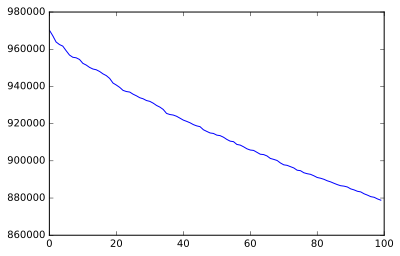

In [9]:
# And the power spectrum is basically flat. It goes
# down a bit because of aliasing effects (I think).
# (The scale is off -- I need to fix that -- but
# for now, just notice that the minimum value is 
# only 10% lower than the maximum value.)

plt.plot(s[0:100])
plt.show()

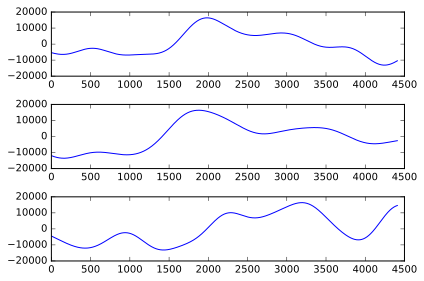

In [10]:
# So we've seen that the SVD creates sinusoidal eigenfunctions
# when we use Brownian noise, and random eigenfunctions when we
# use white noise. What about when we use a mixture of 
# deterministic functions and brownian noise? Let's start
# by creating some random base modes:

base_modes = [noise.white_squarefilter(sample_width=0.05).wav().reshape(-1, 1) / 2
              for x in range(3)]
xbins = 10
ybins = 5
plt.subplot(3, 1, 1)
plt.plot(base_modes[0])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.subplot(3, 1, 2)
plt.plot(base_modes[1])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.subplot(3, 1, 3)
plt.plot(base_modes[2])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.tight_layout()
plt.show()

# Here's what they look like:

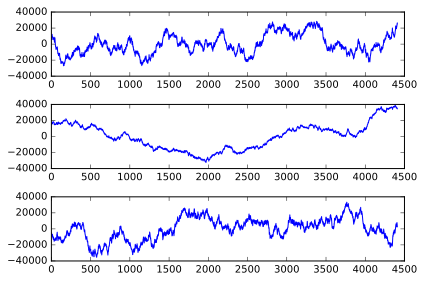

In [11]:
# Now we pick a random base mode and add some Brownian
# noise to it...

selector = numpy.random.random(len(base_modes[0])) * 3
selector = selector.astype('int')
modes = [base_modes[x] for x in selector]
fixed_arcs = [noise.brownian().wav().reshape(-1, 1) + mode 
              for x, mode in zip(range(2000), modes)]

fixed_arcs = numpy.hstack(fixed_arcs)

plt.subplot(3, 1, 1)
plt.plot(fixed_arcs[:,0])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.subplot(3, 1, 2)
plt.plot(fixed_arcs[:,1])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.subplot(3, 1, 3)
plt.plot(fixed_arcs[:,2])
plt.locator_params(axis='x', nbins=xbins)
plt.locator_params(axis='y', nbins=ybins)
plt.tight_layout()
plt.show()

# It's hard to tell the difference between this and 
# plain old Brownian noise, right? 

In [12]:
U, s, V = numpy.linalg.svd(fixed_arcs, full_matrices=False)
numpy.allclose(fixed_arcs, U @ numpy.diag(s) @ V)

True

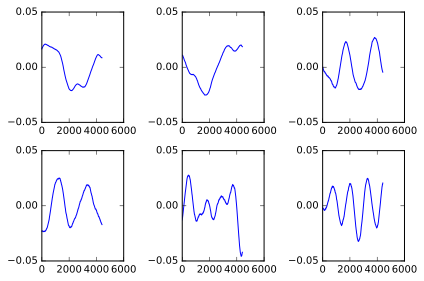

In [13]:
nbins = 3
plt.subplot(2, 3, 1)
plt.plot(U[:,0].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 2)
plt.plot(U[:,1].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 3)
plt.plot(U[:,2].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 4)
plt.plot(U[:,3].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 5)
plt.plot(U[:,4].reshape(-1))
plt.locator_params(nbins=nbins)
plt.subplot(2, 3, 6)
plt.plot(U[:,5].reshape(-1))
plt.locator_params(nbins=nbins)
plt.tight_layout()
plt.show()

# But not to the SVD! It picks up right away that there's
# some hidden structure here: